In [1]:
import pandas as pd

# Load the dataset provided by the user
file_path = 'merged_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035


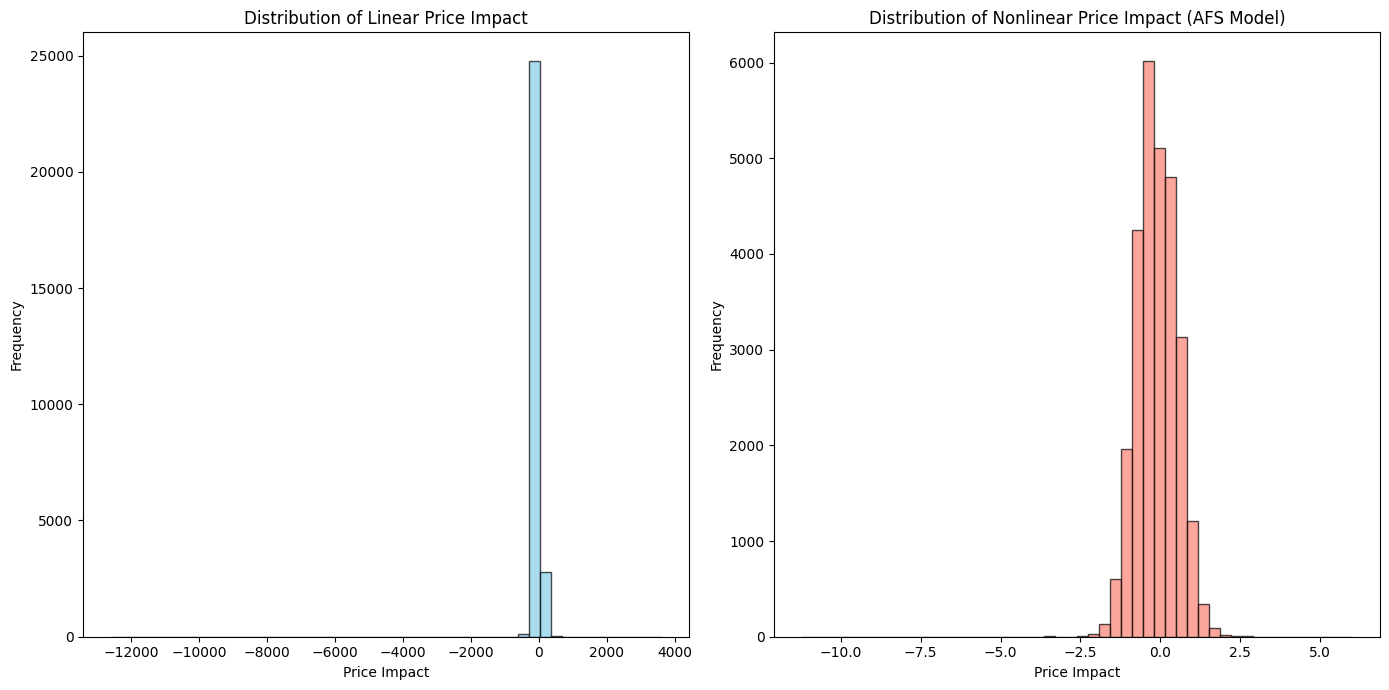

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters for the models
lambda_linear = 0.01  # Linear impact coefficient (arbitrary value for demonstration)
lambda_nonlinear = 0.01  # Nonlinear impact coefficient (arbitrary value for demonstration)
p_nonlinear = 0.5  # Power for nonlinear model

# Compute price impacts
data['linear_impact'] = lambda_linear * data['Signed Volume']
data['nonlinear_impact'] = lambda_nonlinear * np.sign(data['Signed Volume']) * np.abs(data['Signed Volume']) ** p_nonlinear

# Plot distributions of price impact
plt.figure(figsize=(14, 7))

# Linear Impact Distribution
plt.subplot(1, 2, 1)
plt.hist(data['linear_impact'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Linear Price Impact')
plt.xlabel('Price Impact')
plt.ylabel('Frequency')

# Nonlinear Impact Distribution
plt.subplot(1, 2, 2)
plt.hist(data['nonlinear_impact'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Distribution of Nonlinear Price Impact (AFS Model)')
plt.xlabel('Price Impact')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


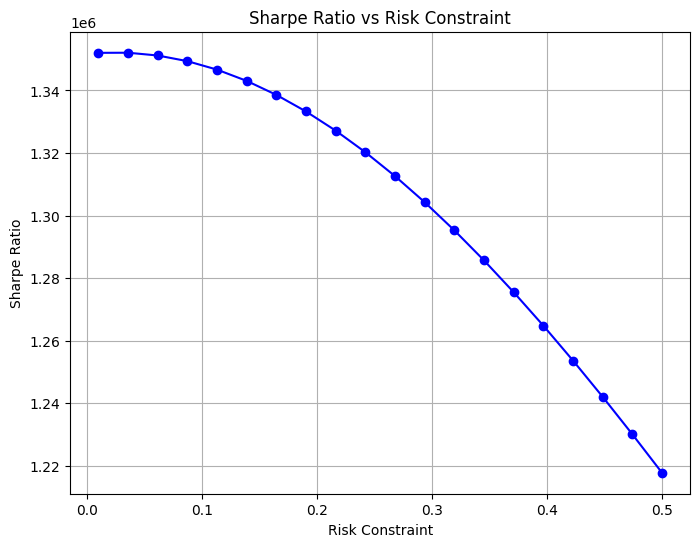

In [3]:
# Define parameters for optimal strategy with linear impact
gamma = 0.1  # Risk aversion parameter (arbitrary value for demonstration)
alpha = 0.01  # Predictive signal strength (arbitrary)
phi = 0.05  # Mean-reversion speed of signal
sigma = 0.02  # Volatility of the signal

# Generate synthetic trading signals for illustration (assuming mean-reverting Ornstein-Uhlenbeck process)
np.random.seed(42)  # For reproducibility
n = len(data)
dt = 1 / 252  # Daily frequency
signal = np.zeros(n)
for t in range(1, n):
    signal[t] = signal[t - 1] * (1 - phi * dt) + np.sqrt(2 * phi * dt) * np.random.normal()

# Add the trading signal to the data
data['signal'] = signal

# Compute the optimal strategy
beta = 0.1  # Impact decay rate
Cf = alpha * (1 + beta / phi) / (gamma * sigma**2 * (np.sqrt(1 + 2 * lambda_linear * beta / (gamma * sigma**2) + beta / phi)))
CJ = np.sqrt(1 + 2 * lambda_linear * beta / (gamma * sigma**2)) - 1

data['optimal_strategy'] = Cf * data['signal'] - CJ * data['linear_impact']

# Compute Sharpe ratio (PnL / Risk)
pnl = Cf * data['signal'] * data['mid_price']
risk = gamma * sigma**2 * data['optimal_strategy'] ** 2
sharpe_ratio = pnl.sum() / np.sqrt(risk.sum())

# Sharpe Ratio plot under different risk constraints
risk_constraints = np.linspace(0.01, 0.5, 20)
sharpe_ratios = []
for risk_constraint in risk_constraints:
    adjusted_Cf = alpha * (1 + beta / phi) / (gamma * sigma**2 * risk_constraint)
    adjusted_strategy = adjusted_Cf * data['signal'] - CJ * data['linear_impact']
    adjusted_pnl = adjusted_Cf * data['signal'] * data['mid_price']
    adjusted_risk = gamma * sigma**2 * adjusted_strategy**2
    sharpe_ratios.append(adjusted_pnl.sum() / np.sqrt(adjusted_risk.sum()))

# Plot Sharpe ratio
plt.figure(figsize=(8, 6))
plt.plot(risk_constraints, sharpe_ratios, marker='o', linestyle='-', color='b')
plt.title('Sharpe Ratio vs Risk Constraint')
plt.xlabel('Risk Constraint')
plt.ylabel('Sharpe Ratio')
plt.grid()
plt.show()


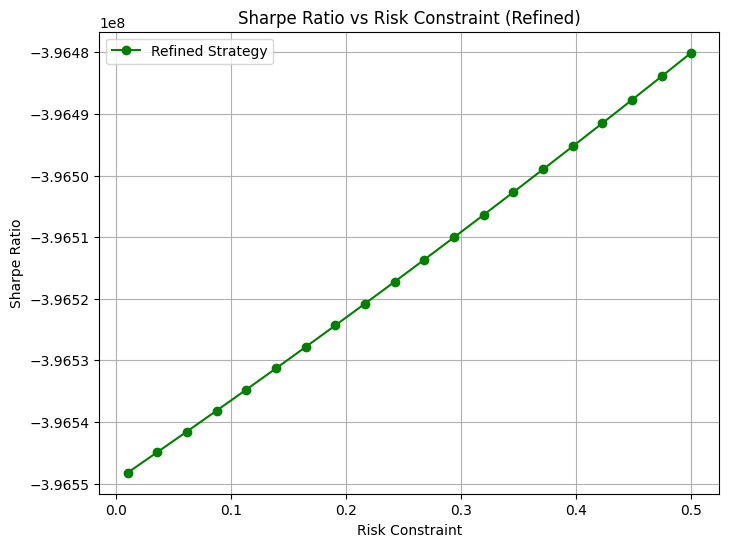

In [4]:
# Step 1: Parameter Estimation from Data
# Estimate volatility (sigma) as the standard deviation of mid-price returns
data['mid_price_return'] = data['mid_price'].pct_change()
sigma_est = data['mid_price_return'].std()

# Estimate mean-reversion (phi) using an autocorrelation approach
autocorr = data['signal'].autocorr(lag=1)
phi_est = -np.log(autocorr) if autocorr > 0 else 0.05  # Fallback to default if autocorr is invalid

# Estimate alpha as the correlation between signal and returns, scaled by volatility
alpha_est = np.corrcoef(data['signal'][1:], data['mid_price_return'][1:])[0, 1] * sigma_est

# Display the estimated parameters
estimated_params = {'Volatility (sigma)': sigma_est, 'Mean-reversion (phi)': phi_est, 'Signal Strength (alpha)': alpha_est}
estimated_params

# Step 2: Incorporate Nonlinear Impact
lambda_nonlinear_refined = 0.02  # Adjusted parameter for nonlinear impact
data['refined_nonlinear_impact'] = lambda_nonlinear_refined * np.sign(data['Signed Volume']) * np.abs(data['Signed Volume']) ** p_nonlinear

# Step 3: Optimal Strategy with Nonlinear Impact
# Recalculate optimal strategy coefficients with estimated parameters
Cf_refined = alpha_est * (1 + beta / phi_est) / (gamma * sigma_est**2 * (np.sqrt(1 + 2 * lambda_nonlinear_refined * beta / (gamma * sigma_est**2) + beta / phi_est)))
CJ_refined = np.sqrt(1 + 2 * lambda_nonlinear_refined * beta / (gamma * sigma_est**2)) - 1

data['optimal_strategy_refined'] = Cf_refined * data['signal'] - CJ_refined * data['refined_nonlinear_impact']

# Compute Sharpe ratio with refined strategy
pnl_refined = Cf_refined * data['signal'] * data['mid_price']
risk_refined = gamma * sigma_est**2 * data['optimal_strategy_refined'] ** 2
sharpe_ratio_refined = pnl_refined.sum() / np.sqrt(risk_refined.sum())

# Sharpe Ratio comparison for different risk constraints
sharpe_ratios_refined = []
for risk_constraint in risk_constraints:
    adjusted_Cf_refined = alpha_est * (1 + beta / phi_est) / (gamma * sigma_est**2 * risk_constraint)
    adjusted_strategy_refined = adjusted_Cf_refined * data['signal'] - CJ_refined * data['refined_nonlinear_impact']
    adjusted_pnl_refined = adjusted_Cf_refined * data['signal'] * data['mid_price']
    adjusted_risk_refined = gamma * sigma_est**2 * adjusted_strategy_refined**2
    sharpe_ratios_refined.append(adjusted_pnl_refined.sum() / np.sqrt(adjusted_risk_refined.sum()))

# Plot refined Sharpe ratio
plt.figure(figsize=(8, 6))
plt.plot(risk_constraints, sharpe_ratios_refined, marker='o', linestyle='-', color='g', label='Refined Strategy')
plt.title('Sharpe Ratio vs Risk Constraint (Refined)')
plt.xlabel('Risk Constraint')
plt.ylabel('Sharpe Ratio')
plt.grid()
plt.legend()
plt.show()


In [7]:
!pip install tools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tools: filename=tools-0.1.9-py3-none-any.whl size=46729 sha256=68eef46754cbc2fc1175689e27a64702a7a5a3db5b61edf6d3b0838a1b7e02ad
  Stored in directory: /root/.cache/pip/wheels/c0/d0/70/a33bd4bed2af4f7038b038c16faab552cd0e9d9f4125223a71
  Created wheel for pytils: filename=pytils-0.4.1-py3-none-any.whl size=32875 sha256=bf80a1f9bf961f45ed32ff9ba218bdf4ef42c381e8ad04620c7783aabbf34efa
  Stored in directory: /root/.cache/pip/wheels/5a/eb/7c/3b6f0c25815749883152b2caca34c35dbaab13ec2864270cbd
Successfully built tools pytils


Scenario Testing Results:
   Scenario  Sharpe Ratio
0         1 -6.437017e+06
1         2 -1.287401e+07
2         3 -1.287404e+07


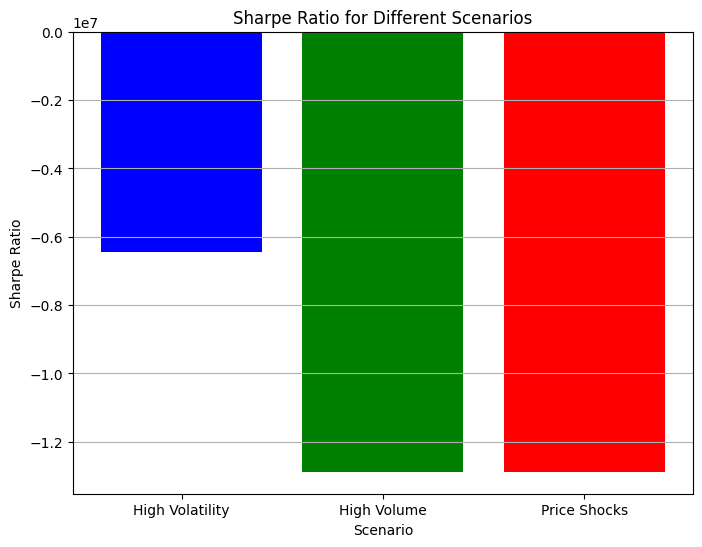

In [11]:
# Step 1: Scenario Testing - Simulate different market conditions

# Generate synthetic scenarios
np.random.seed(42)  # Reproducibility
n_scenarios = 3  # Number of scenarios
scenario_data = []

for i in range(n_scenarios):
    # High volatility scenario
    if i == 0:
        scenario_volatility = sigma_est * 2  # Double the volatility
    # Extreme trading volume scenario
    elif i == 1:
        scenario_volatility = sigma_est
        data['Signed Volume'] *= 2  # Double the trading volume
    # Sudden price shocks
    else:
        scenario_volatility = sigma_est
        price_shock = np.random.normal(0, sigma_est * 10, size=len(data))  # Add shocks
        data['mid_price'] += price_shock

    # Recalculate optimal strategy for each scenario
    data['scenario_signal'] = data['signal'] + np.random.normal(0, scenario_volatility, len(data))
    data['scenario_strategy'] = (
        Cf_refined * data['scenario_signal'] - CJ_refined * data['refined_nonlinear_impact']
    )
    scenario_pnl = Cf_refined * data['scenario_signal'] * data['mid_price']
    scenario_risk = gamma * scenario_volatility**2 * data['scenario_strategy'] ** 2
    scenario_sharpe = scenario_pnl.sum() / np.sqrt(scenario_risk.sum())
    scenario_data.append({'Scenario': i + 1, 'Sharpe Ratio': scenario_sharpe})

# Step 2: Performance Visualization
scenario_df = pd.DataFrame(scenario_data)

# Print the scenario test results
print("Scenario Testing Results:")
print(scenario_df)

# Plot Sharpe ratios for different scenarios
plt.figure(figsize=(8, 6))
plt.bar(scenario_df['Scenario'], scenario_df['Sharpe Ratio'], color=['blue', 'green', 'red'])
plt.title('Sharpe Ratio for Different Scenarios')
plt.xlabel('Scenario')
plt.ylabel('Sharpe Ratio')
plt.xticks(ticks=scenario_df['Scenario'], labels=['High Volatility', 'High Volume', 'Price Shocks'])
plt.grid(axis='y')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 13734098.0000 - mae: 2941.7251 - val_loss: 6464219.0000 - val_mae: 2158.0127
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5623607.5000 - mae: 1772.5906 - val_loss: 1152684.5000 - val_mae: 945.2435
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2763663.2500 - mae: 912.4609 - val_loss: 743946.1875 - val_mae: 722.4576
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5415811.0000 - mae: 782.9273 - val_loss: 605631.1250 - val_mae: 636.5008
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1527492.3750 - mae: 648.1831 - val_loss: 531996.7500 - val_mae: 591.3370
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 955071.1250 - mae: 604.2592 - val_loss: 489852.6875 - val_mae: 573.2350
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 795371.8750 - mae: 589.4893 - val_loss: 451861.6562 - val_mae: 553.8213
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10956

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 10868260.0000 - mae: 1957.1381 - val_loss: 582780.0000 - val_mae: 327.8786
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5504474.0000 - mae: 419.7342 - val_loss: 311355.7500 - val_mae: 255.6888
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 894755.4375 - mae: 326.2794 - val_loss: 201581.9219 - val_mae: 245.2352
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 857318.9375 - mae: 316.3649 - val_loss: 140304.5625 - val_mae: 208.5014
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 554018.4375 - mae: 292.2932 - val_loss: 100968.7734 - val_mae: 186.2181
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1234457.8750 - mae: 323.7218 - val_loss: 73370.1406 - val_mae: 155.5822
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 905391.8125 - mae: 296.4223 - val_loss: 68981.6719 - val_mae: 146.6776
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 164185.0000 - mae: 270.9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


693/693 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 5673687.5000 - mae: 1322.2561 - val_loss: 250311.5000 - val_mae: 318.0279
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1979889.3750 - mae: 439.8405 - val_loss: 93193.0234 - val_mae: 188.7596
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 434615.9062 - mae: 354.6746 - val_loss: 129249.2969 - val_mae: 203.2009
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 319418.1875 - mae: 326.2518 - val_loss: 199334.5938 - val_mae: 311.1702
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 261362.7031 - mae: 323.0001 - val_loss: 91936.0547 - val_mae: 141.0340
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 189565.7656 - mae: 289.4581 - val_loss: 153249.6250 - val_mae: 152.4428
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 169489.5156 - mae: 280.0026 - val_loss: 119957.0859 - val_mae: 131.4998
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 146319.7656 - mae: 258.784

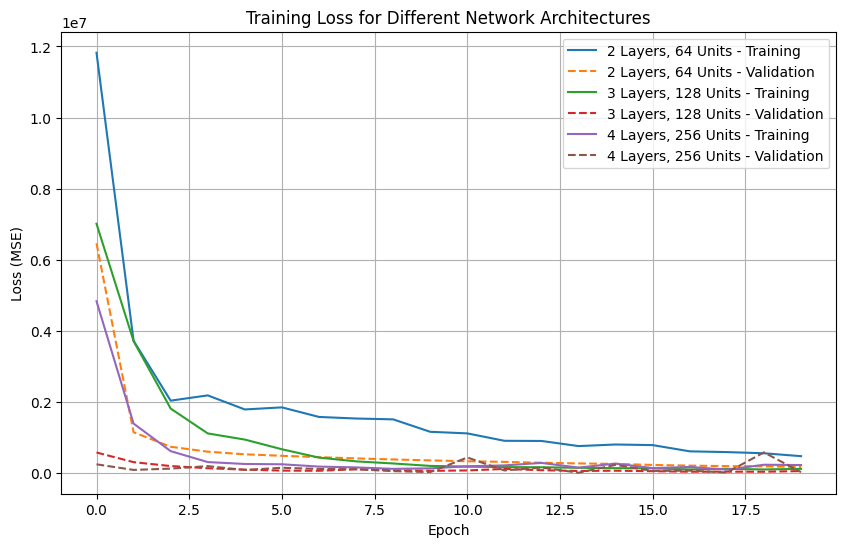

In [13]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
# Make sure to upload your dataset file (merged_data.csv) in Google Colab

# Preprocess the data
features = data[['signal', 'Signed Volume', 'mid_price']]
targets = data['optimal_strategy_refined']

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, targets, test_size=0.2, random_state=42)

# Define the deep learning model function
def build_model(hidden_layers=2, units_per_layer=64, dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(units_per_layer, activation='relu', input_shape=(X_train.shape[1],)))
    for _ in range(hidden_layers - 1):
        model.add(Dense(units_per_layer, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))  # Output layer for strategy prediction
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train models with different architectures
history_records = {}
architectures = [(2, 64), (3, 128), (4, 256)]  # Varying layers and units
for layers, units in architectures:
    model = build_model(hidden_layers=layers, units_per_layer=units)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)
    history_records[f"{layers} Layers, {units} Units"] = history.history

# Visualize training loss
plt.figure(figsize=(10, 6))
for arch, hist in history_records.items():
    plt.plot(hist['loss'], label=f'{arch} - Training')
    plt.plot(hist['val_loss'], linestyle='dashed', label=f'{arch} - Validation')
plt.title('Training Loss for Different Network Architectures')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()
